In [1]:
import pandas as pd
import numpy as np
import os
import math

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
root_dir = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/WH04/4A_outputs/"

MINUTES_PER_FRAME = 90

experiments = {
    "B3" : "Control",
    "B4" : "MyoD",
    "B6" : "PRRX1/MyoD",
    "C3" : "Control",
    "C4" : "MyoD",
    "C6" : "PRRX1/MyoD",
}


df_list = []

for _dir, condition in experiments.items():
    tracks_path = f"{root_dir}{_dir}/Track statistics.csv"
    tracks = pd.read_csv(tracks_path)
    
    spots_path = f"{root_dir}{_dir}/All Spots statistics.csv"
    spots = pd.read_csv(spots_path)
    
    # convert types
    spots = spots[spots['TRACK_ID'] != "None"]
    spots = spots.astype({"TRACK_ID": int})
    
    tracks = tracks.astype({"TRACK_ID": int})
    
    # merge 
    tmp = pd.merge(spots, tracks, how='left', on=['TRACK_ID'])
    
    # sort by ID then FRAME
    tmp = tmp.sort_values(by=['TRACK_ID', 'FRAME'])

    # add a grouped step 
    tmp.loc[:, 'STEP'] =  tmp.groupby(['TRACK_ID']).cumcount()
    tmp.loc[:, 'NORMED_STEP'] = tmp['STEP'] / tmp['TRACK_DURATION']
    
    tmp['Scene'] = _dir
    tmp['Condition'] = condition
    tmp['Time'] = (tmp['FRAME'] * MINUTES_PER_FRAME) / 60
    
    tmp['TRACK_ID'] = tmp['TRACK_ID'].astype(str) + "_" + str(_dir)
    df_list.append(tmp)
    
    
df = pd.concat(df_list, ignore_index=True)

df.head()

,Label_x,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,LINEARITY_OF_FORWARD_PROGRESSION,MEAN_DIRECTIONAL_CHANGE_RATE,TOTAL_ABSOLUTE_ANGLE_XY,TOTAL_ABSOLUTE_ANGLE_YZ,TOTAL_ABSOLUTE_ANGLE_ZX,STEP,NORMED_STEP,Scene,Condition,Time
0,ID625932,625932,0_B3,2.278,0.0,98.409,0,0.000,0,9.5,...,0.182,NaN,-0.827,3.142,1.571,0,0.000000,B3,Control,0.0
1,ID617385,617385,0_B3,3.455,0.0,97.726,0,6173.168,1,9.5,...,0.182,NaN,-0.827,3.142,1.571,1,0.000012,B3,Control,1.5
2,ID640833,640833,0_B3,2.768,0.0,99.092,0,12346.336,2,9.5,...,0.182,NaN,-0.827,3.142,1.571,2,0.000025,B3,Control,3.0
3,ID620269,620269,0_B3,3.307,0.0,110.027,0,18519.504,3,9.5,...,0.182,NaN,-0.827,3.142,1.571,3,0.000037,B3,Control,4.5
4,ID602559,602559,0_B3,2.760,0.0,154.447,0,24692.672,4,9.5,...,0.182,NaN,-0.827,3.142,1.571,4,0.000050,B3,Control,6.0


In [3]:
# subset the columns to make processing easier
cols = [
    'TRACK_ID', 
    'QUALITY', 
    'SNR',
    'POSITION_X',
    'POSITION_Y',
    'FRAME', 
    'Time',
    'STEP',
    'NORMED_STEP',
    'RADIUS',
    'MEAN_INTENSITY01', 
    'MEAN_INTENSITY02',
    'MEAN_INTENSITY03',
    'MEAN_TRACK_INTENSITY01',
    'MEAN_TRACK_INTENSITY02',
    'MEAN_TRACK_INTENSITY03',
    'TOTAL_DISTANCE_TRAVELED',
    'TRACK_DURATION',
    'Scene',
    'Condition'
]

df = df[cols]

df.head()

,TRACK_ID,QUALITY,SNR,POSITION_X,POSITION_Y,FRAME,Time,STEP,NORMED_STEP,RADIUS,MEAN_INTENSITY01,MEAN_INTENSITY02,MEAN_INTENSITY03,MEAN_TRACK_INTENSITY01,MEAN_TRACK_INTENSITY02,MEAN_TRACK_INTENSITY03,TOTAL_DISTANCE_TRAVELED,TRACK_DURATION,Scene,Condition
0,0_B3,2.278,0.537,0.0,98.409,0,0.0,0,0.000000,9.5,0.00,0.0,114.950,2.162,0.0,135.201,168.187,80251.184,B3,Control
1,0_B3,3.455,0.981,0.0,97.726,1,1.5,1,0.000012,9.5,0.00,0.0,125.157,2.162,0.0,135.201,168.187,80251.184,B3,Control
2,0_B3,2.768,0.677,0.0,99.092,2,3.0,2,0.000025,9.5,0.00,0.0,76.070,2.162,0.0,135.201,168.187,80251.184,B3,Control
3,0_B3,3.307,1.016,0.0,110.027,3,4.5,3,0.000037,9.5,0.00,0.0,140.329,2.162,0.0,135.201,168.187,80251.184,B3,Control
4,0_B3,2.760,0.651,0.0,154.447,4,6.0,4,0.000050,9.5,12.42,0.0,72.094,2.162,0.0,135.201,168.187,80251.184,B3,Control


In [4]:
# normalize the intensities and create binary flags
df['mCherry'] = df['MEAN_INTENSITY01'] / 255
df['mVenus'] = df['MEAN_INTENSITY02']  / 255
df['H2B'] = df['MEAN_INTENSITY03']  / 255

# normalize to the highest intensity in the track
df['track_mCherry_max'] = df.groupby('TRACK_ID')['mCherry'].transform(np.max)
df['track_mVenus_max'] = df.groupby('TRACK_ID')['mVenus'].transform(np.max)

df['normed_mCherry'] = df['mCherry'] / df['track_mCherry_max']
df['normed_mVenus'] =df['mVenus'] / df['track_mVenus_max']

# binary flags for track that have any detetable PF signal
df['ANY_mCherry'] = np.where(df['mCherry'] > 0, 1, 0)
df['ANY_mVenus'] = np.where(df['mVenus'] > 0, 1, 0)
df['ANY_H2B'] = np.where(df['H2B'] > 0, 1, 0)

df['has_mCherry'] = df.groupby(['TRACK_ID', 'Condition'])['ANY_mCherry'].transform(np.max)
df['has_mVenus'] = df.groupby(['TRACK_ID', 'Condition'])['ANY_mVenus'].transform(np.max)
df['has_H2B'] = df.groupby(['TRACK_ID', 'Condition'])['ANY_H2B'].transform(np.max)

In [5]:
QUALITY_THRESHOLD = 1.8
MIN_MAX_STEP = 10

# exclude tracks with no positive PF signal
print(df.shape)
print(df['TRACK_ID'].nunique())

# filter for positive PF signal
df = df[df['has_mVenus'] == 1]
df = df[df['has_mCherry'] == 1]

# create mean track quality and SNR measures
df['mean_quality'] = df.groupby(['TRACK_ID'])['QUALITY'].transform(np.mean)
df['max_step'] = df.groupby(['TRACK_ID'])['STEP'].transform(np.max)

df = df[df['mean_quality'] > QUALITY_THRESHOLD]
df = df[df['max_step'] > MIN_MAX_STEP]

print(df.shape)
print(df['TRACK_ID'].nunique())

(338216, 33)
31471
(110209, 35)
6366


Text(0, 0.5, 'Mean mCherry Signal')

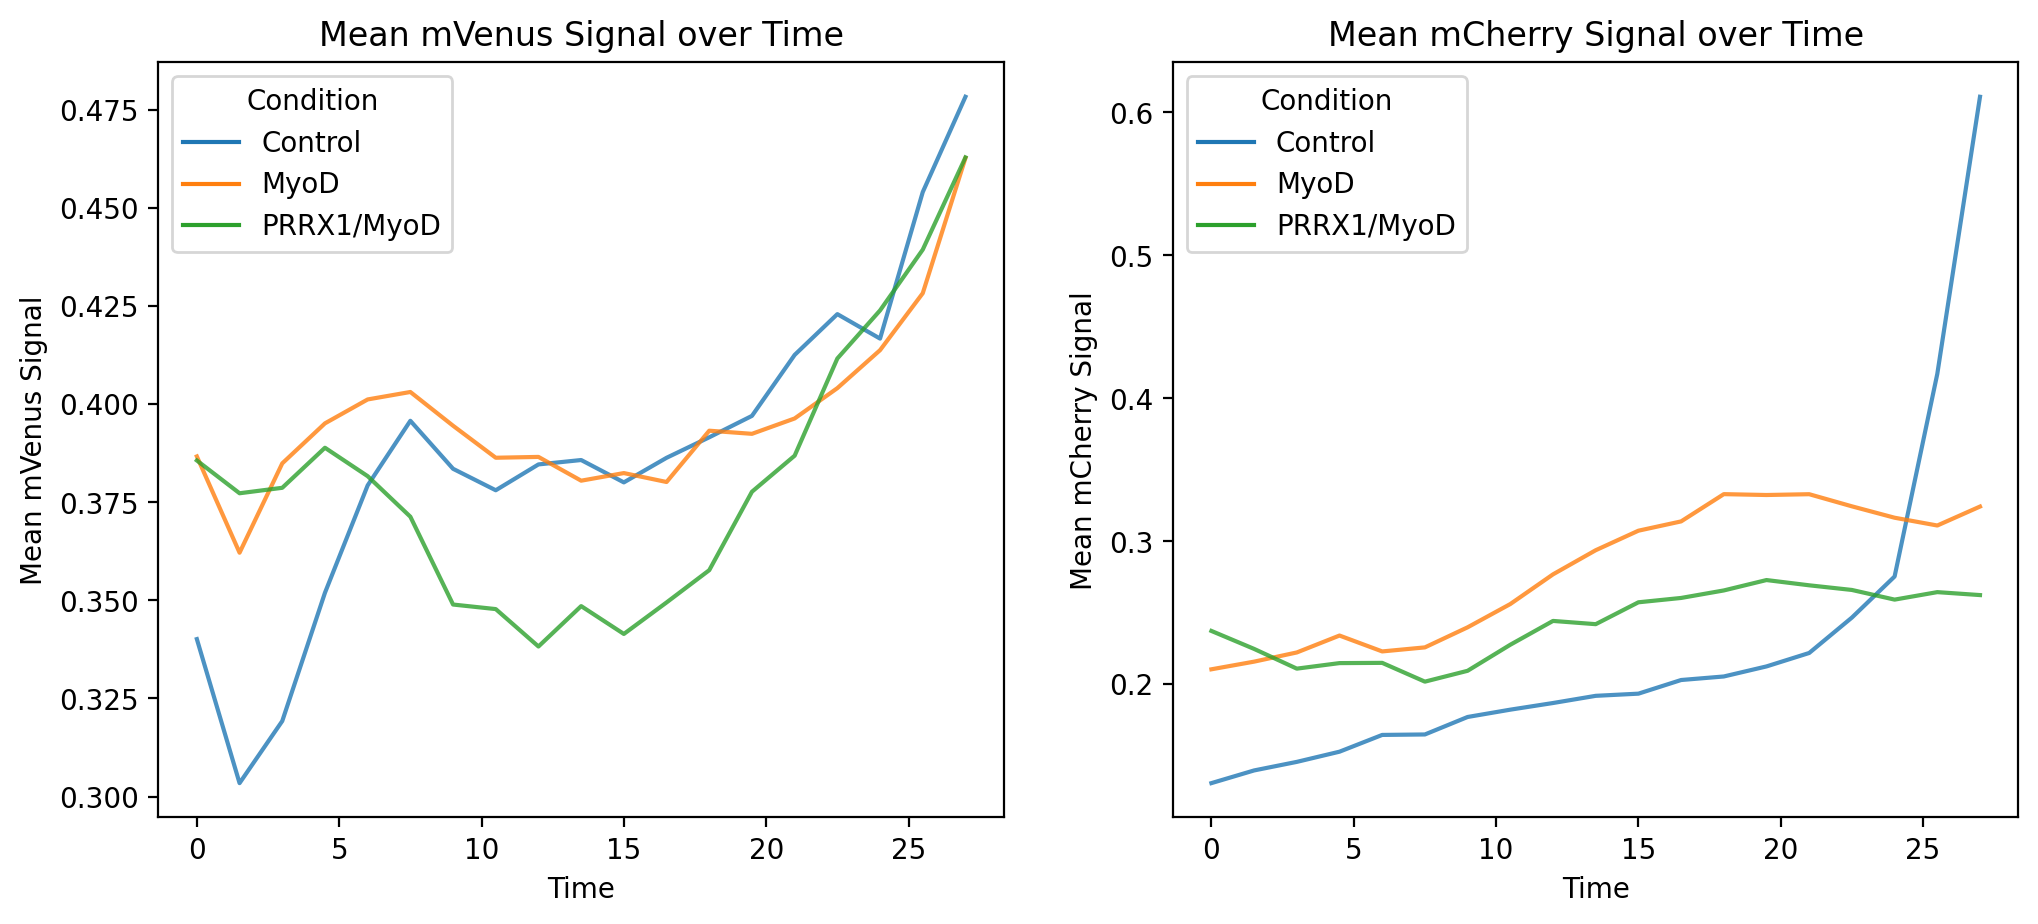

In [6]:
# frame-based normalization factors
grped = df.groupby(['Time', 'Condition'], as_index=False).agg(
    mCherry_mean = ('normed_mCherry', np.mean),
    mCherry_std = ('normed_mCherry', np.std),
    mCherry_median = ('normed_mCherry', np.median),
    
    mVenus_mean = ('normed_mVenus', np.mean),
    mVenus_std = ('normed_mVenus', np.std),
    mVenus_median = ('normed_mVenus', np.median),
)


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 12, 5

fig, axs = plt.subplots(1, 2)

sns.lineplot(data=grped,
             x='Time',
             y='mVenus_mean',
             hue='Condition',
             alpha=0.8,
             ax=axs[0])

axs[0].set_title("Mean mVenus Signal over Time")
axs[0].set_ylabel("Mean mVenus Signal")

sns.lineplot(data=grped,
             x='Time',
             y='mCherry_mean',
             hue='Condition',
             alpha=0.8,
             ax=axs[1])

axs[1].set_title("Mean mCherry Signal over Time")
axs[1].set_ylabel("Mean mCherry Signal")

In [7]:
df.columns

Index(['TRACK_ID', 'QUALITY', 'SNR', 'POSITION_X', 'POSITION_Y', 'FRAME',
       'Time', 'STEP', 'NORMED_STEP', 'RADIUS', 'MEAN_INTENSITY01',
       'MEAN_INTENSITY02', 'MEAN_INTENSITY03', 'MEAN_TRACK_INTENSITY01',
       'MEAN_TRACK_INTENSITY02', 'MEAN_TRACK_INTENSITY03',
       'TOTAL_DISTANCE_TRAVELED', 'TRACK_DURATION', 'Scene', 'Condition',
       'mCherry', 'mVenus', 'H2B', 'track_mCherry_max', 'track_mVenus_max',
       'normed_mCherry', 'normed_mVenus', 'ANY_mCherry', 'ANY_mVenus',
       'ANY_H2B', 'has_mCherry', 'has_mVenus', 'has_H2B', 'mean_quality',
       'max_step'],
      dtype='object')

In [8]:
df = pd.merge(df, grped, on=['Time', 'Condition'], how='left')

#state decision rules
df['mVenus_BINARY'] = np.where(df['normed_mVenus'] > df['mVenus_median'], 1, 0)
df['mCherry_BINARY'] = np.where(df['normed_mCherry'] > df['mCherry_median'], 1, 0)

df['state_guess'] = np.where((df['mVenus_BINARY'] == 1) & (df['mCherry_BINARY'] == 1 ), 'G2/M', 'G1')
df['state_guess'] = np.where((df['mVenus_BINARY'] == 0) & (df['mCherry_BINARY'] == 1 ), 'S', df['state_guess'])

print(df['state_guess'].value_counts(dropna=False))

G1      65235
G2/M    22748
S       22226
Name: state_guess, dtype: int64


Text(0.5, 1.0, '1921_B6')

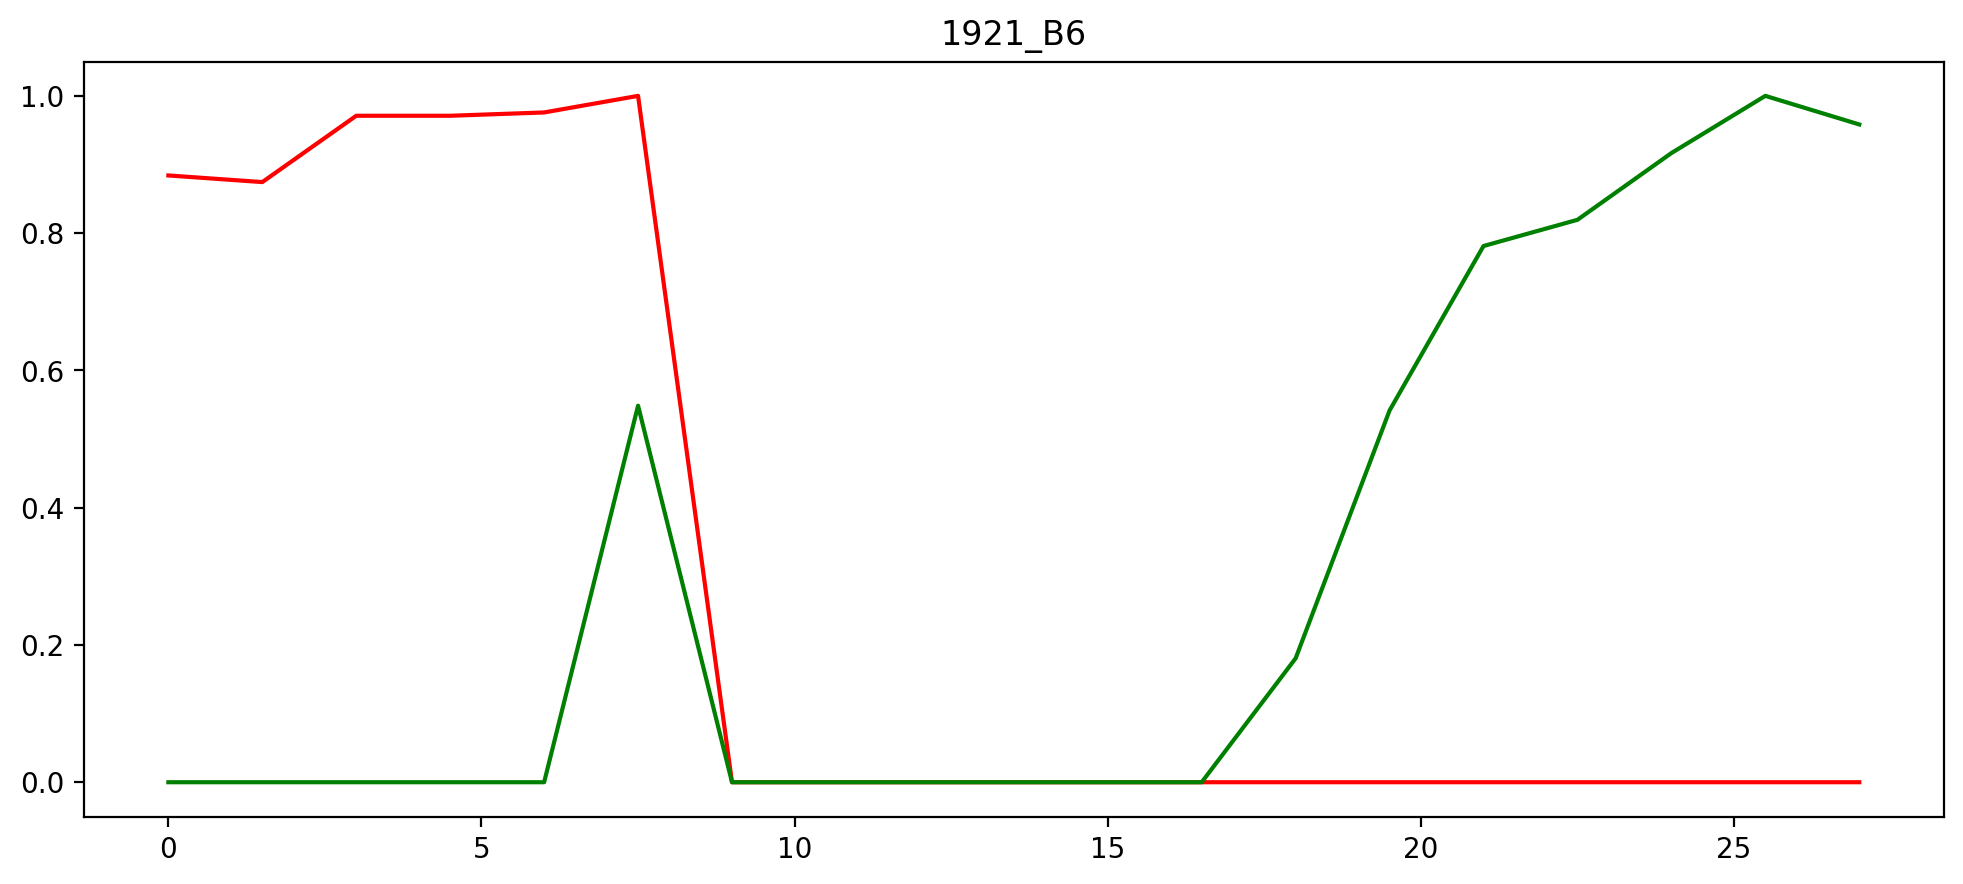

In [12]:

rid = np.random.choice(df['TRACK_ID'], 1)[0]
# rid = "33_B5"
# rid = "143_D5"

tmp = df[df['TRACK_ID'] == rid]

plt.plot(tmp['Time'], tmp['normed_mCherry'], c='r')
plt.plot(tmp['Time'], tmp['normed_mVenus'], c='g')
plt.title(rid)

Text(0.5, 1.0, 'Initial Cell Phase Estimate')

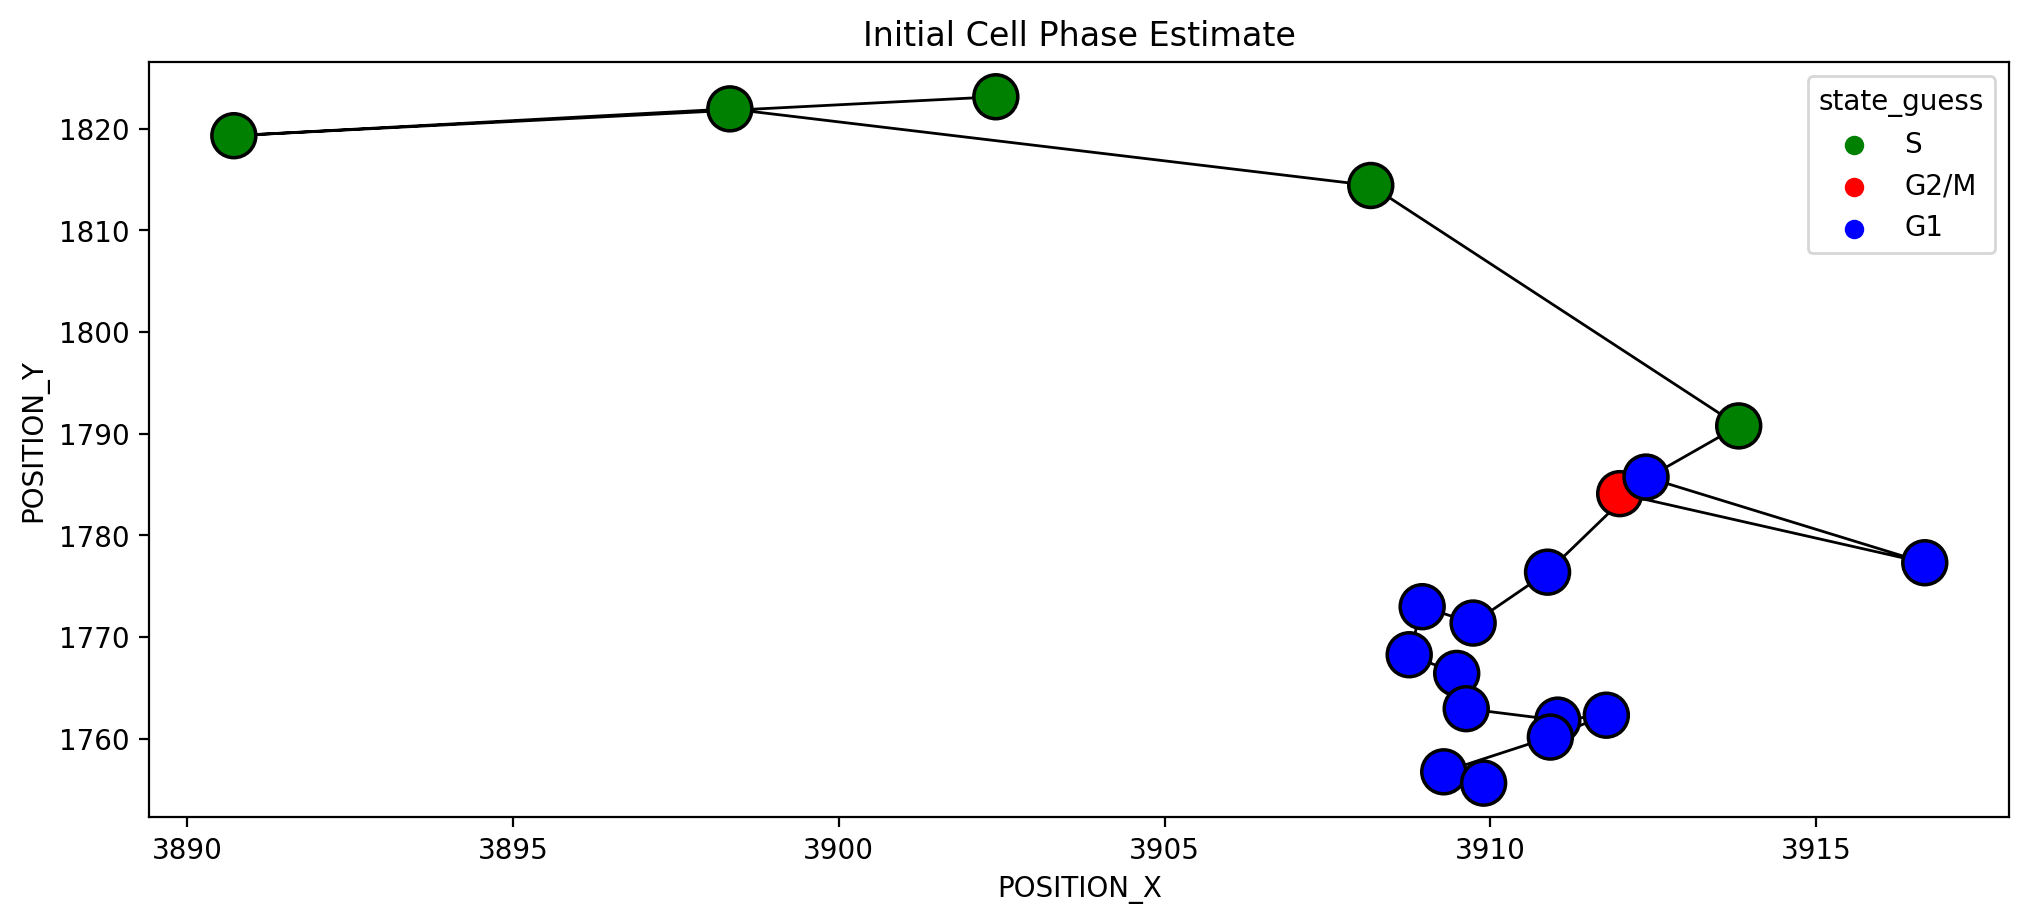

In [13]:
tmp = df[df['TRACK_ID'] == rid]
tmp = tmp.sort_values(by='FRAME')

plt.plot(tmp['POSITION_X'], 
        tmp['POSITION_Y'],
        lw=1,
        c='k',
        zorder=0)

sns.scatterplot(data=tmp,
                x='POSITION_X', 
                y='POSITION_Y',
                s=250,
                hue='state_guess',
                edgecolor='k',
                palette=['g', 'r', 'b'])

plt.title("Initial Cell Phase Estimate")

In [ ]:
transitions = {
    "G1" : "S",
    "S" : "G2/M",
    "G2/M" : "G1",
}


state_dfs = []

for tid in df['TRACK_ID']:
    
    tmp = df[df['TRACK_ID'] == tid].sort_values(by=['TRACK_ID', 'FRAME'])
    
    states = tmp['state_guess'].to_list()
    
    for i, s in enumerate(states):
        if i > 0:
            prev_state = states[i - 1]
            curr_state = states[i]
            
            if not curr_state == transitions[prev_state]:
                states[i] = prev_state
                
    tmp['updated_guess'] = states
    state_dfs.append(tmp)

states = pd.concat(state_dfs, ignore_index=True)
states.head()

In [ ]:
tmp = states[states['TRACK_ID'] == rid]

tmp = tmp.sort_values(by='FRAME')

plt.plot(tmp['POSITION_X'], 
        tmp['POSITION_Y'],
        lw=1,
        c='k',
        zorder=0)

sns.scatterplot(data=tmp,
                x='POSITION_X', 
                y='POSITION_Y',
                s=250,
                hue='updated_guess',
                edgecolor='k',
                palette=['g', 'r', 'b'])

plt.title("Updated Cell Phase Estimate")

In [ ]:
y = pd.get_dummies(states['updated_guess'])
states = states.join(y)
states.head()

In [ ]:
grped = states.groupby(['Time', 'Condition'], as_index=False).agg(
    sum_G1 = ('G1', np.sum),
    sum_S = ('S', np.sum),
    sum_G2 = ('G2/M', np.sum),
)

grped.head()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 6

colors = {
    "PRRX1" : "r",
    "Control" : "b",
    "MyoD" : "k",
    "Twist2" : "g"
}

fig, axs = plt.subplots(3, sharex=True)

for cond in grped['Condition'].unique():
    tmp = grped[grped['Condition'] == cond]
    
    axs[0].plot(tmp['Time'], 
             tmp['sum_G1'], 
             label=cond, 
             c=colors[cond], 
             lw=1)
    
    axs[0].set_title("Estimated Cells in G1")
    axs[0].set_ylabel("Cell Count")
    axs[0].legend(title='Condition', bbox_to_anchor=(1.32, 0.5), loc=7)
    
    axs[1].plot(tmp['Time'], 
         tmp['sum_S'], 
         label=cond, 
         c=colors[cond], 
         lw=1)
    
    axs[1].set_title("Estimated Cells in S")
    axs[1].set_ylabel("Cell Count")
    axs[1].legend(title='Condition', bbox_to_anchor=(1.32, 0.5), loc=7)
    
    
    axs[2].plot(tmp['Time'], 
         tmp['sum_G2'], 
         label=cond, 
         c=colors[cond], 
         lw=1)

    axs[2].set_title("Estimated Cells in G2/M")
    axs[2].set_ylabel("Cell Count")
    axs[2].legend(title='Condition', bbox_to_anchor=(1.32, 0.5), loc=7)

In [ ]:
control = grped[grped['Condition'] == 'Control']
myod = grped[grped['Condition'] == 'MyoD']
prrx1 = grped[grped['Condition'] == 'PRRX1']
twist2 = grped[grped['Condition'] == 'Twist2']

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 13, 13
fig, axs = plt.subplots(2,2)

"""
CONTROL
"""

axs[0, 0].plot(control['Time'], 
               control['sum_G1'], 
               label='G1', 
               c='g', 
               lw=1)


axs[0, 0].plot(control['Time'], 
               control['sum_S'], 
               label='S', 
               c='r', 
               lw=1)


axs[0, 0].plot(control['Time'], 
               control['sum_G2'], 
               label='G2/M', 
               c='y', 
               lw=1)

axs[0, 0].set_title("Control")
axs[0, 0].set_ylabel("N Cells")
axs[0, 0].set_xlabel("Time (hrs)")
axs[0, 0].legend()

"""
MYOD
"""

axs[0, 1].plot(myod['Time'], 
               myod['sum_G1'], 
               label='G1', 
               c='g', 
               lw=1)


axs[0, 1].plot(myod['Time'], 
               myod['sum_S'], 
               label='S', 
               c='r', 
               lw=1)


axs[0, 1].plot(myod['Time'], 
               myod['sum_G2'], 
               label='G2/M', 
               c='y', 
               lw=1)

axs[0, 1].set_title("MyoD")
axs[0, 1].set_ylabel("N Cells")
axs[0, 1].set_xlabel("Time (hrs)")
axs[0, 1].legend()


"""
PRXX1
"""

axs[1, 0].plot(prrx1['Time'], 
               prrx1['sum_G1'], 
               label='G1', 
               c='g', 
               lw=1)


axs[1, 0].plot(prrx1['Time'], 
               prrx1['sum_S'], 
               label='S', 
               c='r', 
               lw=1)


axs[1, 0].plot(prrx1['Time'], 
               prrx1['sum_G2'], 
               label='G2/M', 
               c='y', 
               lw=1)

axs[1, 0].set_title("PRXX1")
axs[1, 0].set_ylabel("N Cells")
axs[1, 0].set_xlabel("Time (hrs)")
axs[1, 0].legend()

"""
Twist2
"""

axs[1, 1].plot(twist2['Time'], 
               twist2['sum_G1'], 
               label='G1', 
               c='g', 
               lw=1)


axs[1, 1].plot(twist2['Time'], 
               twist2['sum_S'], 
               label='S', 
               c='r', 
               lw=1)


axs[1, 1].plot(twist2['Time'], 
               twist2['sum_G2'], 
               label='G2/M', 
               c='y', 
               lw=1)

axs[1, 1].set_title("Twist2")
axs[1, 1].set_ylabel("N Cells")
axs[1, 1].set_xlabel("Time (hrs)")
axs[1, 1].legend()

In [ ]:
for tid in df['TRACK_ID'].unique():
    tmp = df[df['TRACK_ID'] == tid]
    
    
    
    plt.plot(tmp['Time'], 
             tmp['mVenus'],
             alpha=0.2,
             c='g',
             lw=1)